In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


In [2]:
import os
import glob
import json
import pandas as pd

def report_model(path):
    info = torch.load(path, map_location='cpu')
    with open(f'{path[:-5]}_args.txt', 'r') as f:
        params = json.load(f)
    ret = {
        'path': path,
        'val_loss': info['val_loss'],
        'train_loss': info['train_loss'],
        'val_tmax': params['val_tmax'],
        'num_train_counties': params['num_train_counties']
    }
    return ret

records = []
for path in glob.glob('models/*.ckpt'):
    records.append(report_model(path))

df = pd.DataFrame.from_records(records, np.arange(len(records)))
df.sort_values('val_loss')

,path,val_loss,train_loss,val_tmax,num_train_counties
1,models/CensusForecasting_gridded.ckpt,0.252889,0.001654,40,0
4,models/CensusForecasting_3060833_all_counties....,0.391562,0.001536,10,31
2,models/CensusForecasting_3067365_all_counties....,0.399263,0.001496,10,31
3,models/CensusForecasting_3068103_all_counties....,0.403627,0.001507,10,31
0,models/CensusForecasting_3067366_all_counties....,0.412297,0.001567,10,31


# Saliency plotting

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342)
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144)
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150)
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235)
170.5 169.0


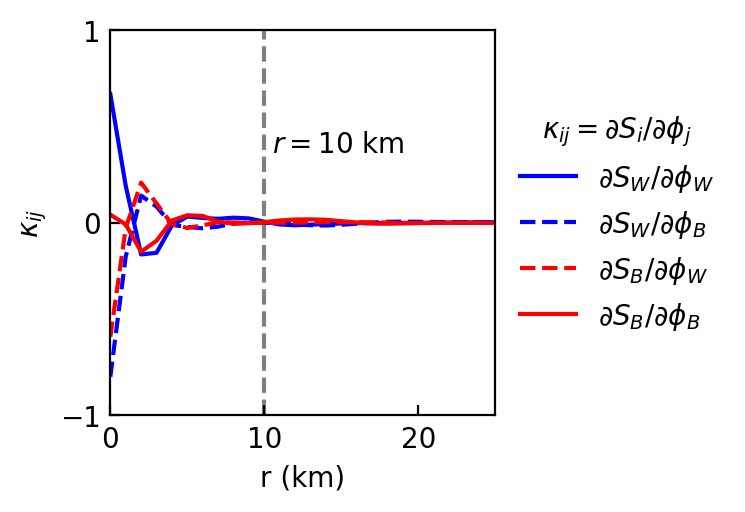

In [3]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

model = 'CensusForecasting_3060833_all_counties' # Best performing model trained on all counties

with h5py.File(f'models/{model}_aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa_{ij}$')
ax.set(
    xlim=[0, 25],
    ylim=[-1, 1],
    xticks=[0, 10, 20],
    yticks=[-1, 0, 1]
)
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 10
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5], title='$\\kappa_{ij} = \\partial S_i / \\partial \\phi_j$')

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342)
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144)
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150)
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235)
170.5 169.0


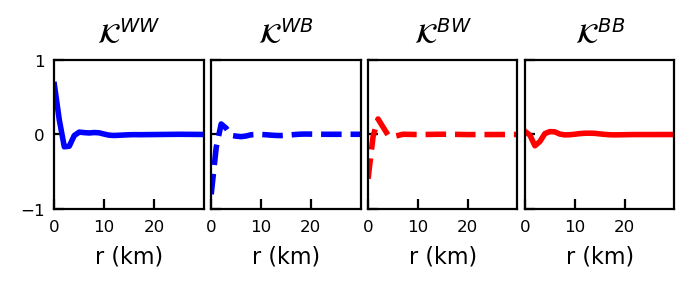

In [26]:
from scipy.interpolate import RectBivariateSpline

G_s, X_s, Y_s = [], [], []

model = 'CensusForecasting_3060833_all_counties' # Best performing model trained on all counties

with h5py.File(f'models/{model}_aggregated_saliency.hdf5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X'])) # Center the coordinates
            Y_s.append(cs['Y'] - np.mean(cs['Y'])) # Center the coordinates
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r))
    for j in range(len(r)):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r, gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(np.round(xmax, 2), np.round(ymax, 2))
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 4, figsize=(4, 1), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    r'$\mathcal{K}^{WW}$',
    r'$\mathcal{K}^{WB}$',
    r'$\mathcal{K}^{BW}$',
    r'$\mathcal{K}^{BB}$',
]

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax[i].plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i], linewidth=2)
    ax[i].set_xlabel('r (km)')

    ax[i].set(
        xlim=[0, 30],
        ylim=[-1, 1],
        xticks=[0, 10, 20],
        yticks=[-1, 0, 1]
    )
    ax[i].set_aspect(np.ptp(ax[i].get_xlim()) / np.ptp(ax[i].get_ylim()))
    ax[i].tick_params(which='both', direction='in')
    ax[i].set_title(labels[i])

fig.subplots_adjust(wspace=0.05)


## Saliency analysis of repeated trials

For sanity checking we compare the saliency reported by our best-performing model to repeated trials of the training process. Note that other trials results in slightly different saliency values but the overall structure of diagonal elements being positive and off-diagonal elements being negative is preserved.

As an additional check, we compare to a model which is overfit to the counties in Figure 3 of the manuscript. This model achieves a lower prediction error (see the table above) and yet the structure of its saliency is qualitatively similar to that of models trained on the full set of US counties.

['models/CensusForecasting_3060833_all_counties_aggregated_saliency.hdf5',
 'models/CensusForecasting_3067365_all_counties_aggregated_saliency.hdf5',
 'models/CensusForecasting_3067366_all_counties_aggregated_saliency.hdf5',
 'models/CensusForecasting_3068103_all_counties_aggregated_saliency.hdf5',
 'models/CensusForecasting_gridded_aggregated_saliency.hdf5']


Text(0.5, 1.0, 'Overfit')

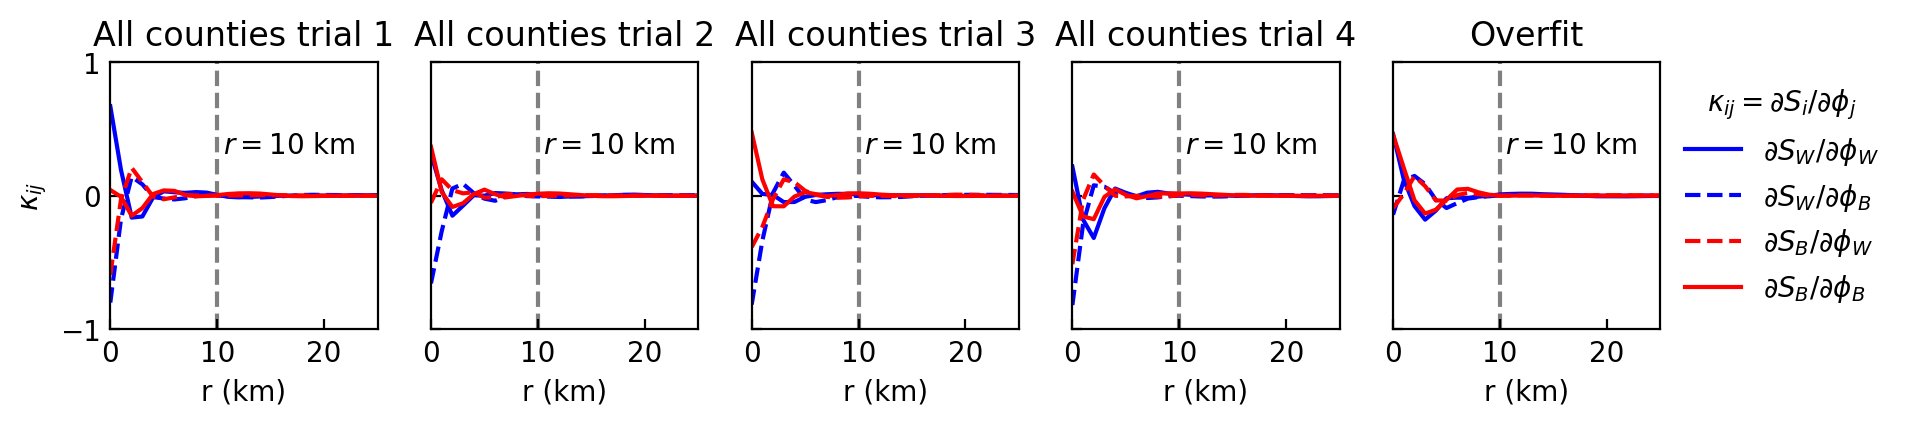

In [5]:
from scipy.interpolate import RectBivariateSpline
import glob
from pprint import pprint

models = sorted(glob.glob('models/CensusForecasting_*_aggregated_saliency.hdf5'))
pprint(models)

fig, ax = plt.subplots(1, len(models), 
                       sharex=True, sharey=True,
                       figsize=(2*len(models), 2.5), dpi=200)

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for mm, model in enumerate(models):
    G_s, X_s, Y_s = [], [], []
    with h5py.File(model, 'r') as h5f:
        for county in h5f.keys():
            cs = h5f[county]
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X']))
            Y_s.append(cs['Y'] - np.mean(cs['Y']))
    
    xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
    ymax = np.max([np.max(Yi) for Yi in Y_s])

    x = np.linspace(-xmax, xmax, 400)
    y = np.linspace(-ymax, ymax, 400)

    for i in range(4):
        r, gr = get_Gr(G_s, i, x, y)
        ax[mm].plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

    ax[mm].set_xlabel('r (km)')
    ax[mm].set(
        xlim=[0, 25],
        ylim=[-1, 1],
        xticks=[0, 10, 20],
        yticks=[-1, 0, 1]
    )
    ax[mm].set_aspect(np.ptp(ax[mm].get_xlim()) / np.ptp(ax[mm].get_ylim()))
        
    r0 = 10
    ax[mm].axvline(r0, linestyle='--', zorder=-1, color='grey')
    ax[mm].text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
                transform=ax[mm].transData)
    ax[mm].tick_params(which='both', direction='in')

ax[-1].legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5], title='$\\kappa_{ij} = \\partial S_i / \\partial \\phi_j$')
ax[0].set_ylabel('$\\kappa_{ij}$')

ax[0].set_title('All counties trial 1')
ax[1].set_title('All counties trial 2')
ax[2].set_title('All counties trial 3')
ax[3].set_title('All counties trial 4')
ax[4].set_title('Overfit')

In [13]:
def aggregate_saliency_data(model):
    # All we ever plotted was G_S_sum anyway so we can git-track that since it's smaller
    with h5py.File(f'models/{model}_saliency.h5', 'r') as h5f:
        with h5py.File(f'models/{model}_aggregated_saliency.hdf5', 'w') as output:
                for county in h5f.keys():
                    cs = output.create_group(county)
                    cs.create_dataset('X', data=h5f[f'{county}/X'][()])
                    cs.create_dataset('Y', data=h5f[f'{county}/Y'][()])
                    cs.create_dataset('G_S_sum', data=h5f[f'{county}/G_S_sum'][()])

model = 'CensusForecasting_gridded' # Best performing model trained on all counties
aggregate_saliency_data(model)